## NLG2. 프로젝트: SentencePiece 사용하기

### Step1. SentencePiece 설치하기

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

import tensorflow as tf
import sentencepiece as spm
import os

### Step2. SentencePiece 모델 학습

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'korean_corpus.zip',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()
    
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
cleaned_corpus = list(set(raw)) #중복제거
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

In [3]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 10000 #E9에서 10000개로 수행해서 일치시킴

with open(temp_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row)+'\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)

!ls -l korean_spm*

-rw-r--r-- 1 aiffel aiffel 416099 10월 13 17:27 korean_spm.model
-rw-r--r-- 1 aiffel aiffel 187188 10월 13 17:27 korean_spm.vocab


In [4]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

### Step 3. Tokenizer함수 작성

In [5]:
def sp_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    #E9에서 pre, maxlen=60으로 패딩하였으므로 맞춤
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'pre', maxlen=60)
    
    return tensor, word_index, index_word

### Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

In [6]:
#데이타 읽어오기
train_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [9]:
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [10]:
#중복제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [11]:
#tokenize 수행
X_train, word_index_train, index_word_train = sp_tokenize(s, train_data.document.values)
X_test, word_index_test, index_word_test = sp_tokenize(s, test_data.document.values)

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [12]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  

from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [13]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

In [14]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1064/1064 [==============================] - 11s 11ms/step - loss: 0.4253 - accuracy: 0.8051 - val_loss: 0.3676 - val_accuracy: 0.8308
Epoch 2/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.3432 - accuracy: 0.8495 - val_loss: 0.3421 - val_accuracy: 0.8457
Epoch 3/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.3060 - accuracy: 0.8685 - val_loss: 0.3403 - val_accuracy: 0.8480
Epoch 4/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.2770 - accuracy: 0.8835 - val_loss: 0.3392 - val_accuracy: 0.8492
Epoch 5/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.2513 - accuracy: 0.8961 - val_loss: 0.3524 - val_accuracy: 0.8508
Epoch 6/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.2272 - accuracy: 0.9079 - val_loss: 0.3731 - val_accuracy: 0.8485
Epoch 7/20
1064/1064 [==============================] - 10s 10ms/step - loss: 0.2040 - accuracy: 0.9182 - val_loss: 0.4092 -

In [15]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

print(model_results)

1537/1537 - 3s - loss: 1.0380 - accuracy: 0.8294
[1.037959337234497, 0.8293834328651428]


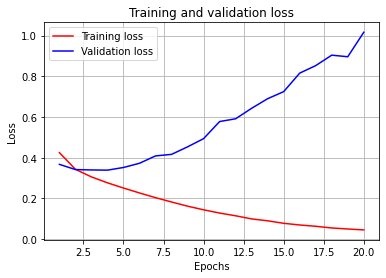

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

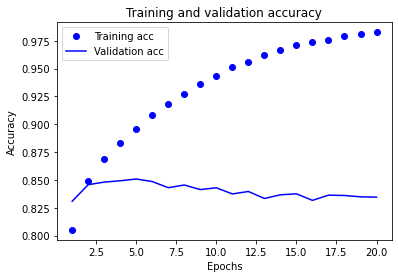

In [17]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### (보너스) SP 모델 변경

In [18]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type={}'.format(temp_file, vocab_size,'bpe')
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel aiffel 409499 10월 13 17:31 korean_spm.model
-rw-r--r-- 1 aiffel aiffel 150722 10월 13 17:31 korean_spm.vocab


In [19]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [20]:
X_train, word_index_train, index_word_train = sp_tokenize(s, train_data.document.values)
X_test, word_index_test, index_word_test = sp_tokenize(s, test_data.document.values)


In [21]:
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1064/1064 [==============================] - 11s 11ms/step - loss: 0.0408 - accuracy: 0.9843 - val_loss: 1.0630 - val_accuracy: 0.8313
Epoch 2/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.0370 - accuracy: 0.9859 - val_loss: 1.0652 - val_accuracy: 0.8338
Epoch 3/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.0359 - accuracy: 0.9864 - val_loss: 1.0773 - val_accuracy: 0.8358
Epoch 4/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.0306 - accuracy: 0.9885 - val_loss: 1.1288 - val_accuracy: 0.8327
Epoch 5/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.0282 - accuracy: 0.9893 - val_loss: 1.1870 - val_accuracy: 0.8330
Epoch 6/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.0287 - accuracy: 0.9893 - val_loss: 1.1662 - val_accuracy: 0.8312
Epoch 7/20
1064/1064 [==============================] - 11s 10ms/step - loss: 0.0245 - accuracy: 0.9907 - val_loss: 1.2104 -

In [22]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

print(model_results)

1537/1537 - 2s - loss: 8.0390 - accuracy: 0.4875
[8.039019584655762, 0.48745855689048767]


- E9의 경우 같은 모델로 학습시킨 결과 정확도 84.10% (Mecab tokenizer)
- SentencePiece의 경우 이보다 낮은 82.94% (unigram), 48.75%(bpe)의 정확도를 보임
- stopwords를 제거하지 않은 것 등의 이유로 정확도가 다소 낮아졌을 가능성이 있음
